In [15]:
# -*- coding: utf-8 -*-
"""run_pkefeedback

Executes a simple transient package that includes:
    - Solution of point kinetic equations
    - Lumped conduction-convection problem
    - Change in reactivity

Created on Tue Oct 12 22:30:00 2021 @author: Dan Kotlyar
Last updated on Wed Oct 13 10:45:00 2021 @author: Dan Kotlyar
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore")

from pkewithfeedback import SimpleTransient, plot1D


# Store kinetic parameters a designated dictionary
# -----------------------------------------------------------------------------
PKE = {}
beta1gr = 0.0075
PKE["beta"] = beta1gr * np.array([0.033, 0.219, 0.196, 0.395, 0.115, 0.042])
beta = PKE["beta"]
PKE["lamda"] = np.array([0.0124, 0.0305, 0.1110, 0.3011, 1.1400, 3.0100])
PKE["promptL"] = 0.001

# Store thermal properties in a designated dictionary
# -----------------------------------------------------------------------------
TH = {}
TH["C_F"] = 200.00     # J/kg/K
TH["C_M"] = 4000.0     # J/kg/K
TH["M_F"] = 40000.     # kg
TH["M_M"] = 7000.0     # kg
TH["W_M"] = 8000.0     # kg/sec
TH["Tin"] = 550.00     # K
TH["h"] = 4E+6         # J/K/sec

# Define metadata parameters and external reactivity scenario
# -----------------------------------------------------------------------------
P0 = 1500E+6     # Nominal power in Watts
P1 = 3000E+6     # Desired power uprate
aF = -1E-05      # drho/dTf
aM = -10E-05      # drho/dTm (associated with density change)

def plotOptimalControl(timepoints, optimal_control):
    plt.figure(1)
    plt.plot(timepoints, optimal_control)
    plt.xlabel("Time (s)")
    plt.ylabel("Reactivity")
    plt.grid()

    plt.figure(2)
    X, T, rho, rhoF = SimpleTransient(timepoints, P0, optimal_control, PKE, TH, aF, 0.1E-05)
    plt.plot(timepoints, X[0, :]/1E+06, label='Calculated')

    _, T = find_final_time(X[0, :], P1, timepoints)
    print(f"FINAL TIME {T}")
    plt.axvline(T, label='Final time')
    plt.axhline(P1/1E+06, linestyle='dashed' ,label="Desired power uprate")
    plt.xlabel("Time (s)")
    plt.ylabel("Power (MW)")
    plt.legend()
    plt.grid()

def getTime(timepoints, control):
    X, _, _, _ = SimpleTransient(timepoints, P0, control, PKE, TH, aF, 0.1E-05)
    index, T = find_final_time(X[0, :], P1, timepoints)
    return (index, T)
    
def ramp(magnitude, timepoints, ramp_time, start_time=0):
    index_tsec = np.argmin(np.abs(timepoints - ramp_time - start_time))
    index_start = np.argmin(np.abs(timepoints - start_time))
    rhoExt = np.zeros(len(timepoints))
    rhoExt[index_start:index_tsec+1] = np.linspace(0, magnitude, len(timepoints[index_start:index_tsec+1]))
    rhoExt[index_tsec+1:] = magnitude*np.ones(len(timepoints[index_tsec+1:]))
    return rhoExt

simulationTime = 240 # s

#---------------------------------
# Defining the Objective Function
#---------------------------------
constraint_violation_penalty = 25

def find_final_time(P, P1, timepoints):
    """Finds the time at which the power is nearly constant (steady state) and equal to
    the desired power P1, if not found, return """
    
    power_uprate_acheived = np.isclose(P[1:]/1E+06, P1/1E+06, atol=10, equal_nan=False)

    derivative_estimate = (np.diff(P)/np.diff(timepoints))/1E+06
    steady_state_solution = np.isclose(0, derivative_estimate, atol=1e-1, equal_nan=False)
    if np.any(np.logical_and(power_uprate_acheived, steady_state_solution)):
        # Get first index where condition was met (the following points are not relevant)
        first_index = np.argmax(np.logical_and(power_uprate_acheived, steady_state_solution))
        return  (first_index, timepoints[first_index])
    else: # Condition was not met, return a distinctive output
        return (None, None)

def overshoot_constraints(rhoExt, P1, timepoints):
    X, T, rho, rhoF = SimpleTransient(timepoints, P0, rhoExt, PKE, TH, aF, 0.1E-05)
    final_time_index, final_time = find_final_time(X[0, :], P1, timepoints)
    if final_time_index is None and final_time is None:
        # print("End point condition not satisfied")
        return -constraint_violation_penalty*1000
    else:
        power_overshoot = np.max(X[0, 0:(final_time_index + 1)]) - P1
        reactivity_overshoot = np.max(rhoExt[0:(final_time_index + 1)]) - beta1gr
        penalty = 1
        # print("End point condition satisfied")
        if power_overshoot > 0:
            # print("Power overshoot")
            penalty -= power_overshoot*constraint_violation_penalty
        if reactivity_overshoot > 0:
            # print("Reactivity overshoot")
            penalty -= reactivity_overshoot*constraint_violation_penalty
        return penalty


def objective_function(rhoExt, P1, timepoints):
    X, T, rho, rhoF = SimpleTransient(timepoints, P0, rhoExt, PKE, TH, aF, 0.1E-05)
    final_time_index, final_time = find_final_time(X[0, :], P1, timepoints)
    # Set initial penalty
    if final_time_index is None and final_time is None:
        # End point conditions not satisfied, return large value
        return 1
    else:
        return final_time/simulationTime


In [33]:
ntstep = 101
timepoints = np.linspace(0, simulationTime, ntstep)

bounds = [(-1, beta1gr) for timepoint in timepoints]

guess = ramp(0.53*beta1gr, timepoints, 6)

constraints = ({'type': 'ineq', 'fun': overshoot_constraints, 'tol': 0.1, 'args': (P1, timepoints)})

optimal_control = minimize(
    objective_function,
    guess,
    method='trust-constr',
    jac='2-point',
    options={
        'verbose': 3, 
        'gtol': 1e-6, 
        'xtol': 1e-6, 
        'maxiter': 1000,
        'initial_constr_penalty': 50.0,
        'initial_tr_radius': 1.0,
        'initial_barrier_tolerance': 0.1
    },
    constraints=constraints,
    args=(P1, timepoints),
    bounds=bounds
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  102  |   0   | +2.0880e+02 | 1.00e+00 | 1.32e+08 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   0   |
|   2   |  204  |   1   | +2.0880e+02 | 5.00e-01 | 1.32e+08 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   2   |
|   3   |  306  |   2   | +2.0880e+02 | 2.50e-01 | 1.32e+08 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   2   |
|   4   |  408  |   3   | +2.0880e+02 | 1.25e-01 | 1.32e+08 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   2   |
|   5   |  510  |   4   | +2.0880e+02 | 6.25e-02 | 1.32e+08 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   2   |
|   6   |  612  |   5   | +2.0880e+02 | 3.12e-02 | 1.32e+08 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   2   |
|   7   |  714  |   6   | +2.0880e+02 | 1.56e-02 | 1.32e+08 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   2   |
|   8   |  816  |   7   | +2.0880e+02 | 7.81e-

In [34]:
optimal_control

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 204.0
                 x: [ 2.631e-11  1.325e-03 ...  3.975e-03  3.975e-03]
               nit: 26
              nfev: 2142
              njev: 21
              nhev: 0
          cg_niter: 54
      cg_stop_cond: 0
              grad: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
   lagrangian_grad: [ 2.382e-07  1.964e-07 ...  1.124e-07  1.124e-07]
            constr: [array([1]), array([ 2.631e-11,  1.325e-03, ...,  3.975e-03,
                            3.975e-03])]
               jac: [array([[ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00]]), array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           ...,
                           [ 0.000e+00,  0.000e+0

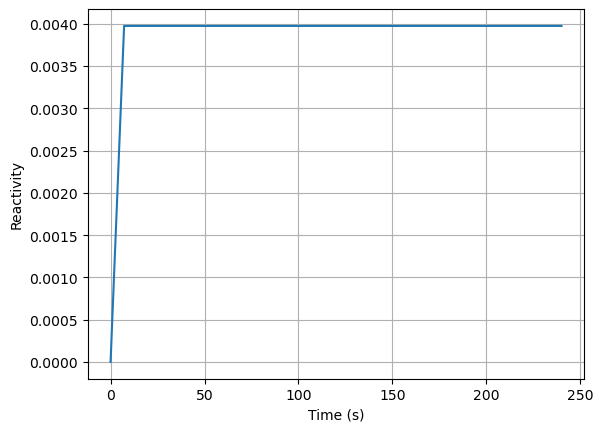

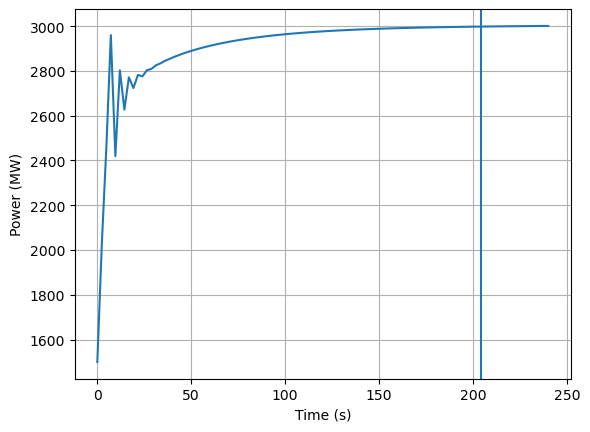

In [36]:
plotOptimalControl(timepoints, optimal_control)

# Allowing overshoot

In [33]:
# Refedine the constraint and objective functions

# Note that now rhoExt has been scaled to beta1gr so that the input quantities are closer to (0,1)
def objective_function(control, P1, timepoints):
    # print(control - guess)
    X, T, rho, rhoF = SimpleTransient(timepoints, P0, control*beta1gr, PKE, TH, aF, 0.1E-05)
    final_time_index, final_time = find_final_time(X[0, :], P1, timepoints)
    # Set initial penalty
    if final_time_index is None and final_time is None:
        # End point conditions not satisfied, return large value
        return 1
    else:
        return final_time/simulationTime

def overshoot_constraints(control, P1, timepoints):
    X, T, rho, rhoF = SimpleTransient(timepoints, P0, control*beta1gr, PKE, TH, aF, 0.1E-05)
    final_time_index, final_time = find_final_time(X[0, :], P1, timepoints)
    if final_time_index is None and final_time is None:
        # print("End point condition not satisfied")
        return -constraint_violation_penalty*1000
    else:
        power_overshoot = np.max(X[0, 0:(final_time_index + 1)]) - 1.5*P1 # Now a nonzero (50%) overshoot is allowed
        reactivity_overshoot = np.max(control[0:(final_time_index + 1)]*beta1gr) - beta1gr
        penalty = 0
        # print("End point condition satisfied")
        if power_overshoot > 0:
            # print("Power overshoot")
            penalty -= power_overshoot/(1.5*P1)
        if reactivity_overshoot > 0:
            # print("Reactivity overshoot")
            penalty -= reactivity_overshoot/beta1gr
        return penalty

In [39]:
ntstep = 101
timepoints = np.linspace(0, simulationTime, ntstep)

bounds = [(-1,  1) for timepoint in timepoints]

guess = ramp(0.53, timepoints, 6)

constraints = ({'type': 'eq', 'fun': overshoot_constraints, 'tol': 0.01, 'args': (P1, timepoints)})

# optimal_control = minimize(
#     objective_function,
#     guess,
#     method='SLSQP',
#     options={
#         'disp': True,
#         'maxiter': 1000,
#         'ftol': 1e-6,  # Tolerance for the objective function
#         'eps': 1.4901161193847656e-08  # Step size for numerical gradient estimation, if needed
#     },
#     constraints=constraints,
#     args=(P1, timepoints),
#     bounds=bounds
# )

optimal_control = minimize(
    objective_function,
    guess,
    method='trust-constr',
    jac={'method': '2-point', 'diff_step': 1e-3},  # Adjust diff_step to see if it affects step size
    options={
        'verbose': 3, 
        'gtol': 1e-6, 
        'xtol': 1e-6,
        'maxiter': 1000,
        'initial_tr_radius': 1E+09,
        'initial_constr_penalty': 0.0,
        'disp': True,
    },
    constraints=constraints,
    args=(P1, timepoints),
    bounds=bounds
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  102  |   0   | +8.7000e-01 | 1.00e+09 | 2.58e-02 | 0.00e+00 | 0.00e+00 |  1.00e-01   |   0   |
|   2   |  204  |   1   | +8.7000e-01 | 1.00e+08 | 2.58e-02 | 0.00e+00 | 0.00e+00 |  1.00e-01   |   4   |
|   3   |  204  |   2   | +8.7000e-01 | 1.00e+07 | 2.58e-02 | 0.00e+00 | 0.00e+00 |  1.00e-01   |   4   |
|   4   |  204  |   3   | +8.7000e-01 | 1.00e+06 | 2.58e-02 | 0.00e+00 | 0.00e+00 |  1.00e-01   |   4   |
|   5   |  204  |   4   | +8.7000e-01 | 1.00e+05 | 2.58e-02 | 0.00e+00 | 0.00e+00 |  1.00e-01   |   4   |
|   6   |  204  |   5   | +8.7000e-01 | 1.00e+04 | 2.58e-02 | 0.00e+00 | 0.00e+00 |  1.00e-01   |   4   |
|   7   |  204  |   6   | +8.7000e-01 | 1.00e+03 | 2.58e-02 | 0.00e+00 | 0.00e+00 |  1.00e-01   |   4   |
|   8   |  204  |   7   | +8.7000e-01 | 1.00e+

FINAL TIME 211.2


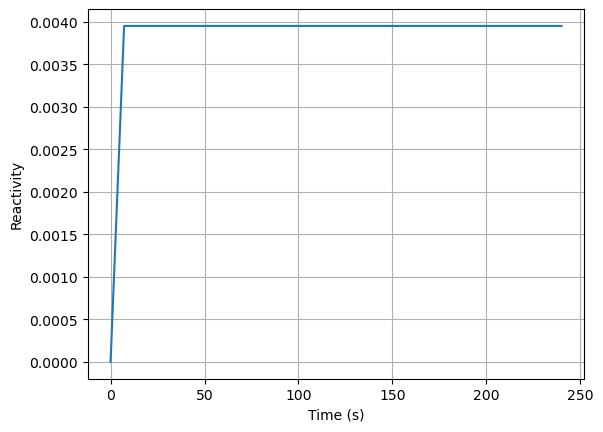

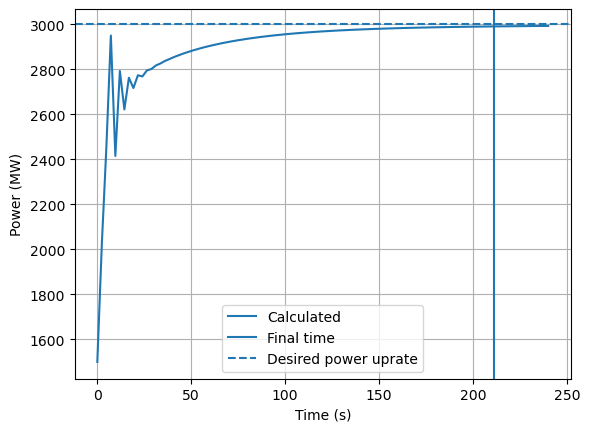

In [40]:
# print(objective_function(guess, P1, timepoints))
# # 
# guess2 = 0.53*np.ones(ntstep)
# print(objective_function(guess2, P1, timepoints))

# plotOptimalControl(timepoints, guess*beta1gr)
# plotOptimalControl(timepoints, guess2*beta1gr)

# print(overshoot_constraints(guess, P1, timepoints))
plotOptimalControl(timepoints, optimal_control.x*beta1gr)